<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_TP1_GRUPO02_ENTREGA_N3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


<font color='#fa5050'>Importante: para correr este notebook es pre-requisito haber corrido los notebooks numero 1 y 2, ya que de lo contrario no se tienen los datasets de train, test y clusters.</font>

# Importación de librerias

In [208]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn import tree

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from xgboost import XGBClassifier

import geopandas as gpd

import joblib

import warnings
warnings.filterwarnings("ignore")

# consts
RAND_SEED = 42

# Lectura de archivo

### Desde google drive

In [211]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"

train_file = drive_path + '/Dataset/ds_train.csv'
test_file = drive_path + '/Dataset/ds_test.csv'
ds_cluster_train_file = drive_path + '/Dataset/ds_cluster_train.csv'
ds_cluster_3_file = drive_path + '/Dataset/ds_cluster_3_groups.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'

ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
ds_train = pd.read_csv(train_file)
ds_test = pd.read_csv(test_file)
ds_cluster_train = pd.read_csv(ds_cluster_train_file)
ds_cluster_3 = pd.read_csv(ds_cluster_3_file)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [ ]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# train_file = './dataset/ds_train.csv'
# test_file = './dataset/ds_test.csv'
# ds_cluster_train_file = './dataset/ds_cluster_train.csv'
# ds_cluster_3_file = './dataset/ds_cluster_3_groups.csv'
# barrios_file = './dataset/barrios.csv'

# ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
# ds_train = pd.read_csv(train_file)
# ds_test = pd.read_csv(test_file)
# ds_cluster_train = pd.read_csv(ds_cluster_train_file)
# ds_cluster_3 = pd.read_csv(ds_cluster_3_file)
# using_drive = False

# Clasificación


## Construcción del target

In [50]:
ds_target_train = ds_train.copy()
ds_target_test = ds_test.copy()

### Creacion de la columna `'precio por metro cuadrado'`

In [51]:
ds_target_train['pxm2'] = ds_target_train['property_price'] / ds_target_train['property_surface_total']

### Evaluacion de limites de categorias de precio

Division igual entre todas las observaciones

In [52]:
ds_target_train['tipo_precio_1'] = pd.qcut(ds_target_train['pxm2'], q=3, labels=['bajo', 'medio', 'alto'])
ds_target_train['tipo_precio_1'].value_counts()

tipo_precio_1
bajo     24074
medio    24074
alto     24068
Name: count, dtype: int64

**Los Q's no tienen exactamente la misma cantidad ya que hay valores duplicados los cuales no pueden pertenecer a diferentes tipos, y hacen que no se pueda hacer una division perfecta.**

Division en 25% - 50% - 25% de observaciones

In [53]:
ds_target_train['tipo_precio_2'] = pd.qcut(ds_target_train['pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])
ds_target_train['tipo_precio_2'].value_counts()

tipo_precio_2
medio    36254
bajo     18054
alto     17908
Name: count, dtype: int64

Division en 25% - 50% - 25% relativo por cada tipo de propiedad

In [54]:
def division_relativa(ds, division, col_name):
  ds[col_name] = '' # inicializo todos a ''

  # Con Departamentos
  departamentos = ds['property_type'] == 'Departamento'
  ds.loc[departamentos, col_name] = pd.qcut(ds.loc[departamentos, 'pxm2'], q=division, labels=['bajo', 'medio', 'alto'])

  # Con Casas
  casas = ds['property_type'] == 'Casa'
  ds.loc[casas, col_name] = pd.qcut(ds.loc[casas, 'pxm2'], q=division, labels=['bajo', 'medio', 'alto'])

  # Con PHs
  phs = ds['property_type'] == 'PH'
  ds.loc[phs, col_name] = pd.qcut(ds.loc[phs, 'pxm2'], q=division, labels=['bajo', 'medio', 'alto'])

division_relativa(ds_target_train, [0, 0.25, 0.75, 1], 'tipo_precio_3')
ds_target_train['tipo_precio_3'].value_counts()

tipo_precio_3
medio    36113
bajo     18057
alto     18046
Name: count, dtype: int64

Division equitativa relativo por cada tipo de propiedad

In [55]:
division_relativa(ds_target_train, 3, 'tipo_precio_4')
ds_target_train['tipo_precio_4'].value_counts()

tipo_precio_4
medio    24077
bajo     24073
alto     24066
Name: count, dtype: int64

* Distribucion del precio por metro cuadrado

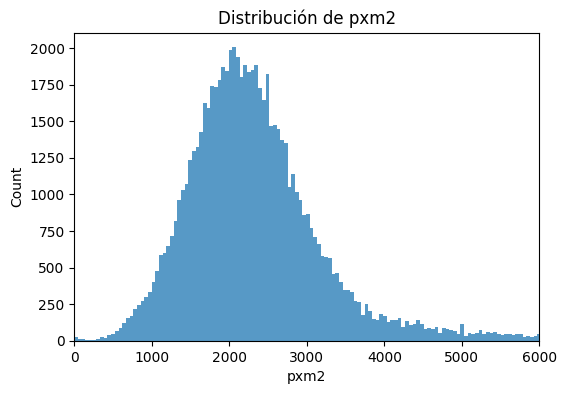

In [39]:
plt.figure(figsize=(6, 4))
sns.histplot(ds_target_train['pxm2'])
plt.title('Distribución de pxm2')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0, 6000)
plt.show()

Se observa una *distribucion normal* con forma de campana de Gauss en la variable pxm2.

* Distribución del precio por metro cuadrado por tipo de propiedad

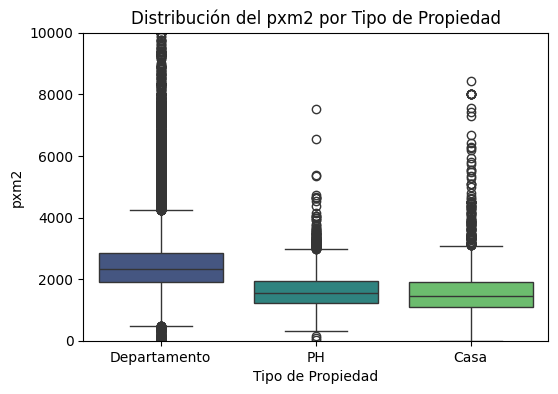

In [40]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='property_type', y='pxm2', data=ds_target_train, palette='viridis')
plt.title('Distribución del pxm2 por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('pxm2')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylim(0, 10000)
plt.show()

* Distribucion de categoria de precio por metodo

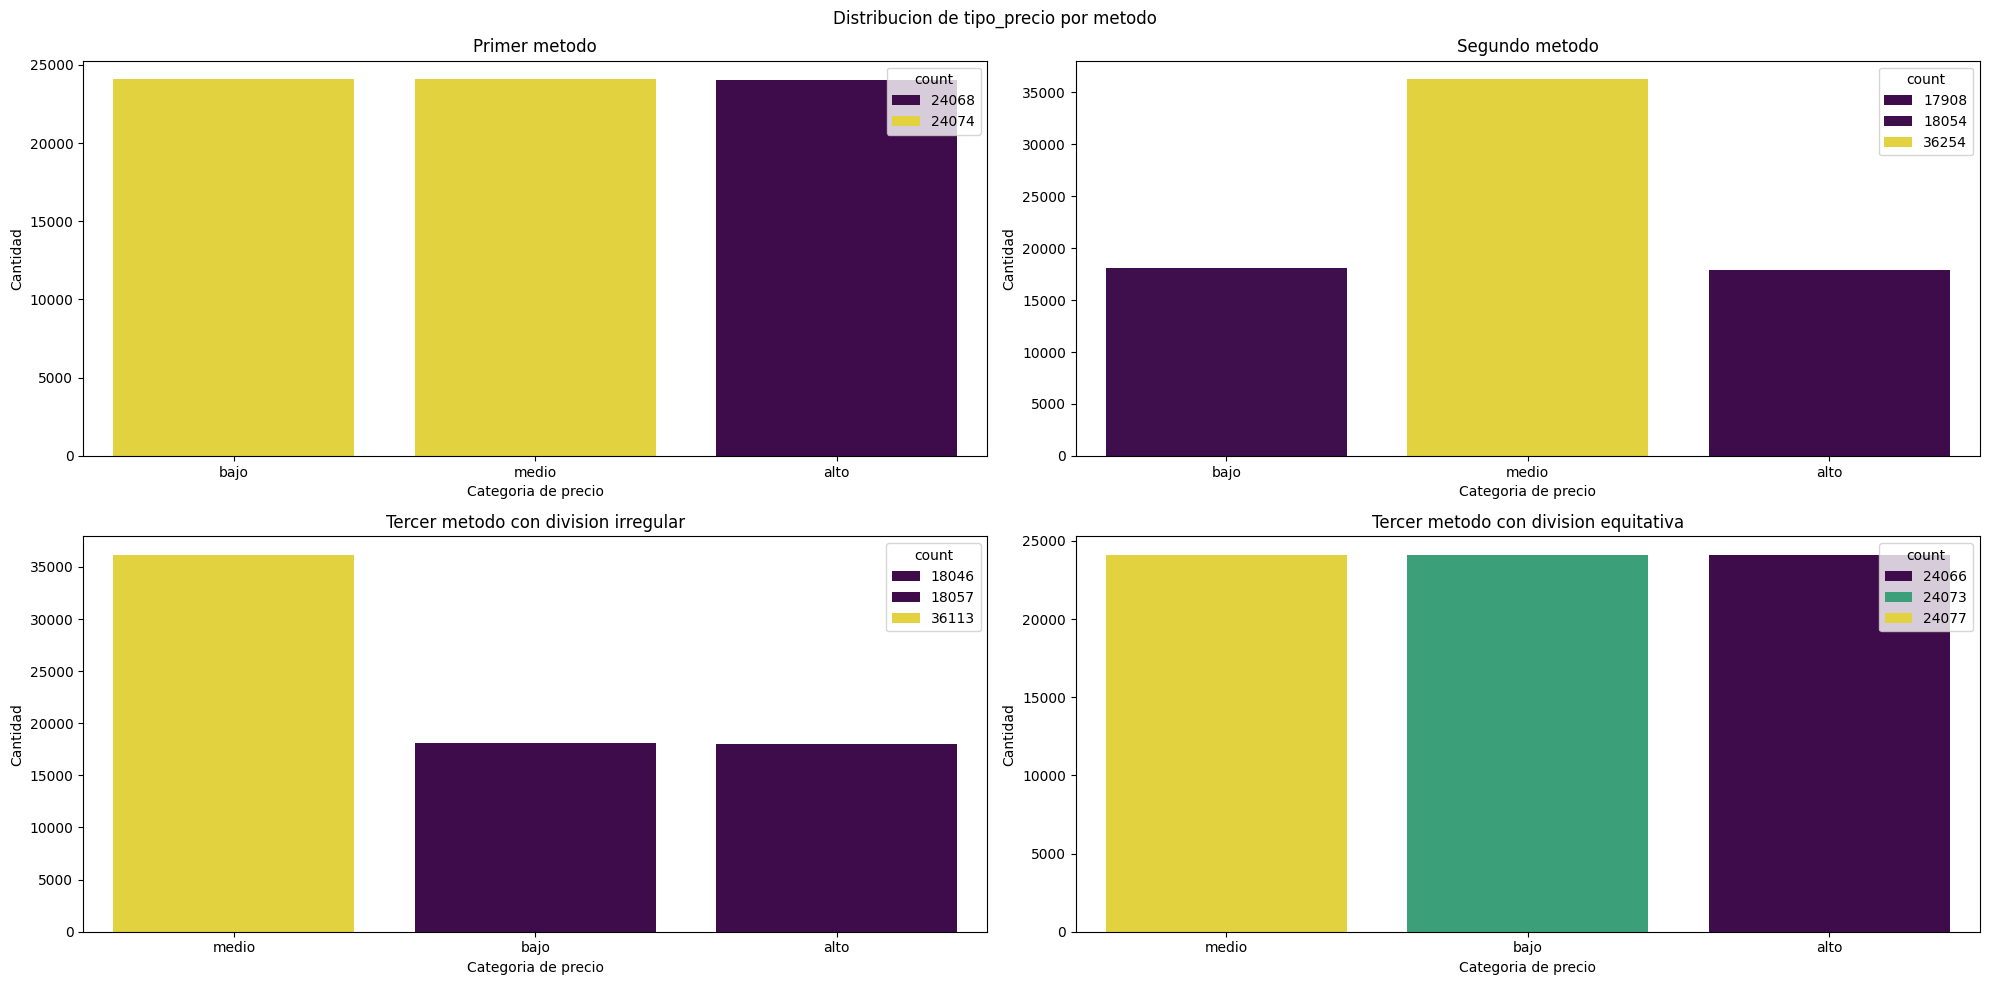

In [56]:
plt.figure(figsize=(20, 10))
plt.suptitle('Distribucion de tipo_precio por metodo')

# Primer metodo
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_target_train["tipo_precio_1"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.index, y=frecuencias_place_3.values, hue=frecuencias_place_3, palette='viridis')
plt.title('Primer metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Segundo metodo
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_target_train["tipo_precio_2"].value_counts()
sns.barplot(x=frecuencias_place_4.index, y=frecuencias_place_4.values, hue=frecuencias_place_4, palette='viridis')
plt.title('Segundo metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Tercer metodo
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_target_train["tipo_precio_3"].value_counts()
sns.barplot(x=frecuencias_property_type.index, y=frecuencias_property_type.values, hue=frecuencias_property_type, palette='viridis')
plt.title('Tercer metodo con division irregular')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Tercer metodo bis
plt.subplot(2, 2, 4) # 2 filas, 2 columnas, 4 posicion
frecuencias_property_type = ds_target_train["tipo_precio_4"].value_counts()
sns.barplot(x=frecuencias_property_type.index, y=frecuencias_property_type.values, hue=frecuencias_property_type, palette='viridis')
plt.title('Tercer metodo con division equitativa')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

### Seleccion de uno de los metodos vistos

Se decidira tomar el **ultimo metodo *(metodo 3)*** ya que tiene en cuenta no solo el ratio *precio/metros cuadrados* sino tambien que tipo de propiedad es, de esta manera se le asigna una clasificacion de precio mucho mas especifica que las otras dos alternativas. A su vez eligiremos dividir equitativamente las observaciones, de manera que no haya desbalances de datos.

Ej: *Los dos anteriores no tienen en cuenta que un precio X puede ser elevado para un departamento pero barato para un PH.*

In [57]:
# Eliminar categorias de precios de los metodos descartados
columnas_a_eliminar = ['tipo_precio_1', 'tipo_precio_2', 'tipo_precio_3']
ds_target_train.drop(columns=columnas_a_eliminar, inplace=True)

# renombrar columna de tipo_precio del metodo a usar
ds_target_train['tipo_precio'] = ds_target_train['tipo_precio_4']
ds_target_train.drop(columns=['tipo_precio_4'], inplace=True)

In [58]:
# Vemos las cols
ds_target_train.dtypes

id                           object
start_date                   object
end_date                     object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
pxm2                        float64
tipo_precio                  object
dtype: object

Aplico el metodo al dataset de test

In [59]:
ds_target_test['pxm2'] = ds_target_test['property_price'] / ds_target_test['property_surface_total']
division_relativa(ds_target_test, 3, 'tipo_precio')

# Vemos las cols
ds_target_test.dtypes

id                           object
start_date                   object
end_date                     object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
pxm2                        float64
tipo_precio                  object
dtype: object

Y esta distribucion en el testing set

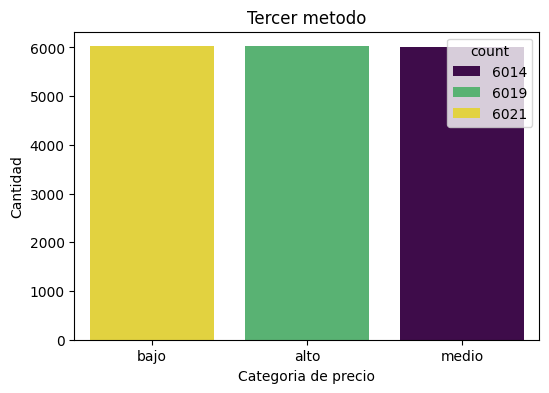

In [60]:
plt.figure(figsize=(6, 4))
frecuencias_property_type = ds_target_test["tipo_precio"].value_counts()
sns.barplot(x=frecuencias_property_type.index, y=frecuencias_property_type.values, hue=frecuencias_property_type, palette='viridis')
plt.title('Tercer metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

plt.show()

### Comparacion con Clusterizacion K=3

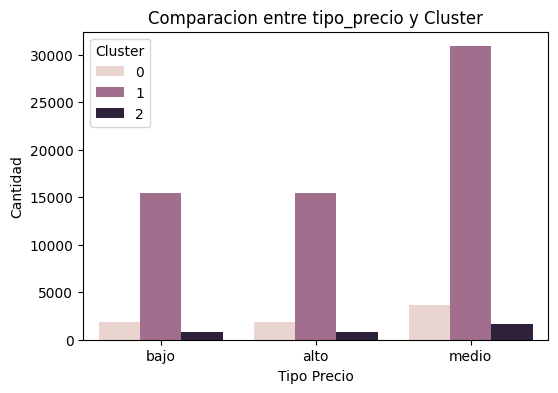

In [14]:
plotting = ds_target_train.copy()
plotting["Cluster"] = ds_cluster_3["Cluster"]

# Create the plot
plt.figure(figsize=(6, 4))
sns.countplot(data=plotting, x='tipo_precio', hue='Cluster')

# Add labels and title
plt.xlabel('Tipo Precio')
plt.ylabel('Cantidad')
plt.title('Comparacion entre tipo_precio y Cluster')

# Show the plot
plt.legend(title='Cluster')
plt.show()

Como descubrimos en el analisis de clusterizacion con k=3 en el Notebook numero 3, Los clusters se crearon a partir del tipo de propiedad, por lo que el anterior grafico nos muestra la cantidad de PHs, Departamentos y Casas dentro de cada categoria de precio.

**Clusters:**

* 0: PH
* 1: Departamento
* 2: Casa

Es decir se ve que la mayoria de propiedades, sea en bajo/medio/alto precio son departamentos, luego le siguen los PHs y luego las casas.

### Categorias de precios en el mapa de CABA

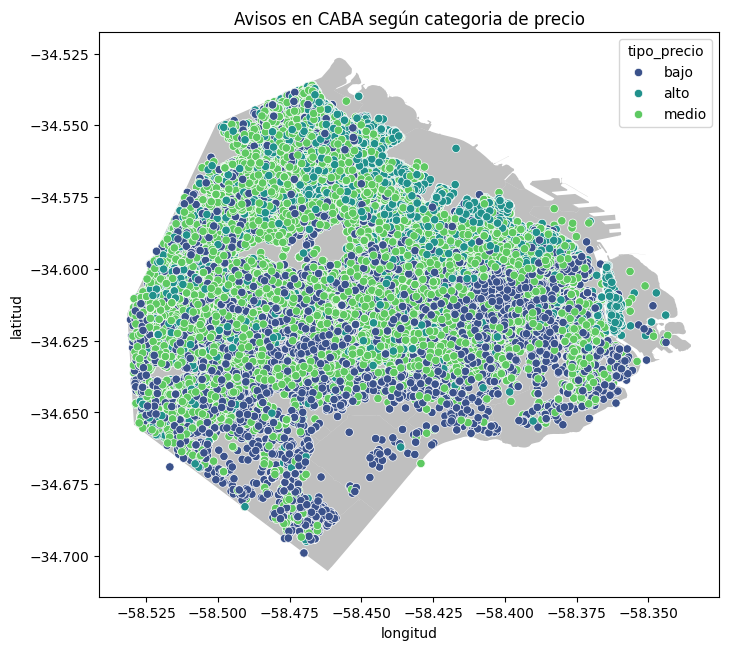

In [15]:
# setup GDF
ds_barrios['geometry'] = gpd.GeoSeries.from_wkt(ds_barrios['WKT'])
gdf_barrios = gpd.GeoDataFrame(ds_barrios, geometry='geometry')

fig, ax = plt.subplots(figsize=(8, 8))

# Graficar los límites de los barrios de CABA
gdf_barrios.plot(ax=ax, color='grey', alpha = 0.5)

# Graficar los puntos coloreados por cluster
sns.scatterplot(ax=ax, data=ds_target_train, x='longitud', y='latitud', hue='tipo_precio', palette='viridis')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Configurar título y etiquetas de los ejes
ax.set(title='Avisos en CABA según categoria de precio')
plt.show()

Si se observa este grafico de CABA vemos que en el sur tenemos mayor densidad de propiedades con **precio bajo** y la categoria incrementa hacia el norte. En el medio de CABA hay mayor cantidad de **precios medios** y en el norte hay mas **precios altos**.

## Entrenamiento y Predicción

En esta sección se va a predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price,
pxm2 y cualquier otra que pueda contener información del precio de venta. Para todos los
modelos se pide realizar las tareas de ingeniería de características necesarias para trabajar
con cada algoritmo (encoding, normalización, etc).


### Ingenieria de caracteristicas

In [158]:
ds_clas_train = ds_target_train.copy()
ds_clas_test = ds_target_test.copy()

cols_a_eliminar = ['property_price', 'pxm2']
ds_clas_train.drop(columns=cols_a_eliminar, inplace=True)
ds_clas_test.drop(columns=cols_a_eliminar, inplace=True)

In [159]:
# Veo las cols actuales
ds_clas_train.dtypes

id                           object
start_date                   object
end_date                     object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
tipo_precio                  object
dtype: object

In [160]:
# Veo las cols actuales
ds_clas_test.dtypes

id                           object
start_date                   object
end_date                     object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
tipo_precio                  object
dtype: object

Columnas consideradas irrelevantes:
* ID de la propiedad
* Las fechas de comienzo/finalizacion de la publicacion
* Latitud y Longitud (ya que el barrio parece ser una mejor y mas confiable opcion a tener en cuenta para la ubicacion)
* Surface covered (debido a que nuestro calculo de pxm2 fue hecho teniendo en cuenta la superficie total y no solo la cubierta, y ademas tienen una correlacion media-alta entre si)
* Property Bedrooms (ya que esta altamente correlacionado con property rooms)

In [161]:
# Eliminamos dichas columnas
cols_a_eliminar = ["id", "start_date", "end_date", "property_surface_covered", "property_bedrooms"]
ds_clas_train.drop(columns=cols_a_eliminar, inplace=True)
ds_clas_test.drop(columns=cols_a_eliminar, inplace=True)
ds_clas_train.dtypes

latitud                   float64
longitud                  float64
place_l3                   object
property_type              object
property_rooms              int64
property_surface_total    float64
tipo_precio                object
dtype: object

Encodeo de variables cualitativas

In [162]:
def encode_non_numerical_vars(ds, col):
  """returns encoding dict and its inverse dict"""
  _col = ds[col].unique()

  _col_dict = dict(zip(_col, range(len(_col))))
  _col_inv_dict = dict(zip(range(len(_col)), _col))

  ds[col] = ds[col].map(_col_dict)
  return _col_dict, _col_inv_dict

In [163]:
# Mapear tipo_precio a una representacion numerica
tipo_precio_dict, tipo_precio_inv_dict = encode_non_numerical_vars(ds_clas_train, "tipo_precio")
_ = encode_non_numerical_vars(ds_clas_test, "tipo_precio")

In [164]:
# one hot encoding para tipo
ds_clas_train = pd.get_dummies(ds_clas_train, columns=["property_type"])
ds_clas_test = pd.get_dummies(ds_clas_test, columns=["property_type"])

In [165]:
# one hot encoding para barrios
ds_clas_train = pd.get_dummies(ds_clas_train, columns=["place_l3"])
ds_clas_test = pd.get_dummies(ds_clas_test, columns=["place_l3"])

Se opto por ***no*** normalizar los valores de las columnas numericas ya que los modelos basados en arboles no se ven afectados por esto.

In [166]:
ds_clas_train.head()

,latitud,longitud,property_rooms,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,place_l3_Abasto,place_l3_Agronomía,...,place_l3_Villa Lugano,place_l3_Villa Luro,place_l3_Villa Ortuzar,place_l3_Villa Pueyrredón,place_l3_Villa Real,place_l3_Villa Riachuelo,place_l3_Villa Santa Rita,place_l3_Villa Soldati,place_l3_Villa Urquiza,place_l3_Villa del Parque
0,-34.621088,-58.375666,4,184.0,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-34.582432,-58.408182,2,41.0,1,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-34.621109,-58.443163,4,185.0,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-34.609959,-58.450973,1,35.0,2,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-34.579111,-58.500674,6,195.0,0,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [167]:
ds_clas_test.head()

,latitud,longitud,property_rooms,property_surface_total,tipo_precio,property_type_Casa,property_type_Departamento,property_type_PH,place_l3_Abasto,place_l3_Agronomía,...,place_l3_Villa Lugano,place_l3_Villa Luro,place_l3_Villa Ortuzar,place_l3_Villa Pueyrredón,place_l3_Villa Real,place_l3_Villa Riachuelo,place_l3_Villa Santa Rita,place_l3_Villa Soldati,place_l3_Villa Urquiza,place_l3_Villa del Parque
0,-34.610057,-58.465636,2,45.0,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,-34.632671,-58.445846,4,186.0,1,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-34.590800,-58.417192,2,53.0,1,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-34.676635,-58.489410,4,69.0,0,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,-34.600597,-58.387820,2,33.0,1,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Modelo 1: Arbol de decisión

#### Construcción
Construir un árbol de decisión y optimizar sus hiperparámetros mediante k-fold Cross
Validation para obtener la mejor performance. ¿Cuántos folds utilizaron? ¿Qué
métrica consideran adecuada para buscar los parámetros?

In [198]:
# Creo x_train para entrenar e y_train para las labels, lo mismo para test
x_train = ds_clas_train.drop(columns=["tipo_precio"])
y_train = ds_clas_train["tipo_precio"].copy()

x_test = ds_clas_test.drop(columns=["tipo_precio"])
y_test = ds_clas_test["tipo_precio"].copy()

##### Cross-validation

In [199]:
kfoldcv = KFold(n_splits=5)
scorer_fn = make_scorer(f1_score, average='macro')
n = 10

dt_model = DecisionTreeClassifier()

params_grid = {
    'criterion': ['gini','entropy'],
    'ccp_alpha': np.linspace(0,0.05,n),
    'max_depth': list(range(1,6))
    }

rs = RandomizedSearchCV(estimator=dt_model, param_distributions=params_grid, scoring=scorer_fn, cv=kfoldcv, n_iter=n, n_jobs=-1)
rs_fit = rs.fit(X = x_train, y = y_train) # entrenamiento
rs_fit.best_score_

0.5374054788503713

Vemos los mejores parametros seleccionados en la validacion cruzada

In [200]:
params_elegidos=rs_fit.cv_results_['params'][np.argmax(rs_fit.cv_results_['mean_test_score'])]
params_elegidos

{'max_depth': 3, 'criterion': 'entropy', 'ccp_alpha': 0.005555555555555556}

##### Creacion del mejor modelo

In [201]:
best_dt = DecisionTreeClassifier(
    criterion = params_elegidos['criterion'],
    ccp_alpha = params_elegidos['ccp_alpha'],
    max_depth = params_elegidos['max_depth'],
)

best_dt_model = best_dt.fit(X = x_train, y = y_train)
y_train_pred_best_dt_model = best_dt_model.predict(x_train)
y_test_pred_best_dt_model = best_dt_model.predict(x_test)

Vemos el performance del arbol en el testing set

              precision    recall  f1-score   support

           0       0.59      0.66      0.63      6021
           1       0.29      0.30      0.29      6014
           2       0.31      0.26      0.28      6019

    accuracy                           0.41     18054
   macro avg       0.40      0.41      0.40     18054
weighted avg       0.40      0.41      0.40     18054



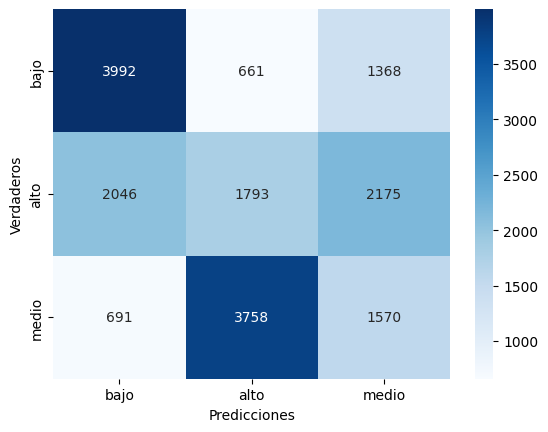

In [202]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test, y_test_pred_best_dt_model)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')

# Replace numeric labels with class representations
center = 0.5
plt.xticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])
plt.yticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])

#Reporte
print(classification_report(y_test, y_test_pred_best_dt_model))

Comparemos con su performance en el training set

              precision    recall  f1-score   support

           0       0.59      0.65      0.62     24073
           1       0.60      0.63      0.61     24066
           2       0.41      0.35      0.38     24077

    accuracy                           0.54     72216
   macro avg       0.53      0.54      0.54     72216
weighted avg       0.53      0.54      0.54     72216



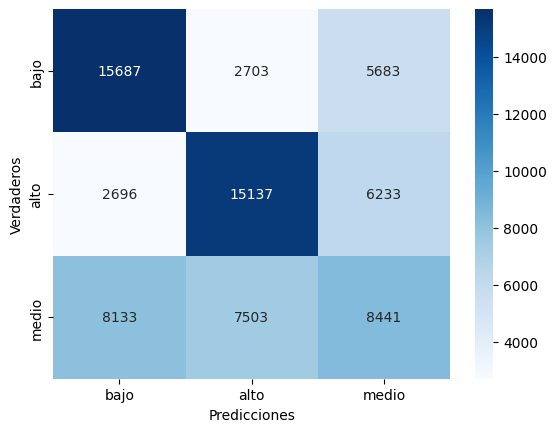

In [203]:
#Creo matriz de confusión
tabla=confusion_matrix(y_train, y_train_pred_best_dt_model)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')

# Replace numeric labels with class representations
center = 0.5
plt.xticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])
plt.yticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])

#Reporte
print(classification_report(y_train, y_train_pred_best_dt_model))

#### Visualizacion del arbol


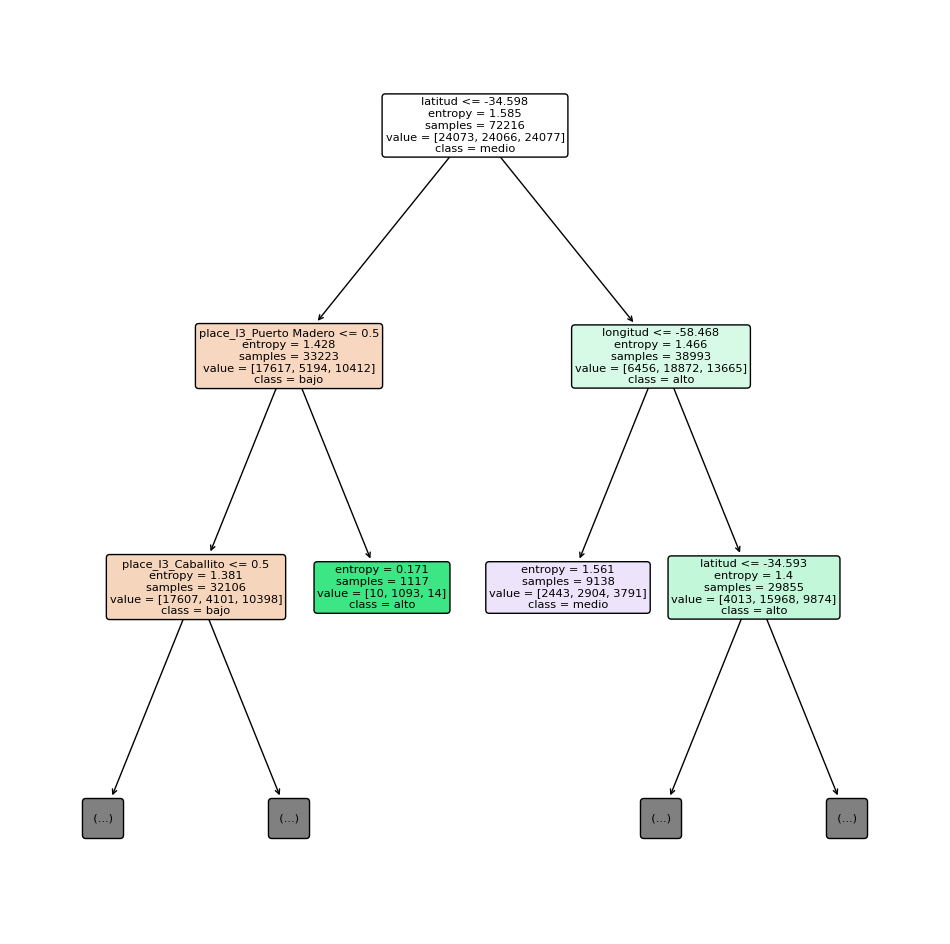

In [204]:
PROFUNDIDAD = 2

plt.figure(figsize=(12,12))
tree_plot=tree.plot_tree(
    best_dt_model,
    max_depth=PROFUNDIDAD,
    feature_names=x_train.columns.to_list(),
    filled=True,
    rounded=True,
    class_names=['bajo', 'alto', 'medio']
    )
plt.show(tree_plot)

#### Importancia de atributos
Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).


Después de la optimización de hiperparámetros, hemos obtenido un árbol de decisión con la siguiente estructura:

Regla inicial: Si la cantidad de habitaciones (property_rooms) es menor o igual a 2.5 (digamos, 2 en nuestro caso), y el tipo de propiedad (property_type) es "departamento", entonces clasifica la propiedad como "precio medio". Regla de desglose: Si la cantidad de habitaciones es mayor que 2.5 y menor o igual a 3.5 (digamos, 3 en nuestro caso), y la superficie total (property_surface_total) es menor o igual a 100 metros cuadrados, entonces clasifica la propiedad como "precio bajo". Otra regla de desglose: Si la cantidad de habitaciones es mayor que 3.5 (digamos, 4 en nuestro caso), y el barrio (place_l3) es "Palermo", entonces clasifica la propiedad como "precio alto". Regla final: Si ninguna de las condiciones anteriores se cumple, entonces clasifica la propiedad como "precio medio". Estas reglas representan las decisiones tomadas por el árbol de decisión para clasificar las propiedades en diferentes categorías de precios. El árbol se ramifica en función de diferentes combinaciones de atributos, como el número de habitaciones, el tipo de propiedad, la superficie total y el barrio. Al seguir las ramas del árbol, podemos ver cómo se evalúan estas características para llegar a una clasificación final.

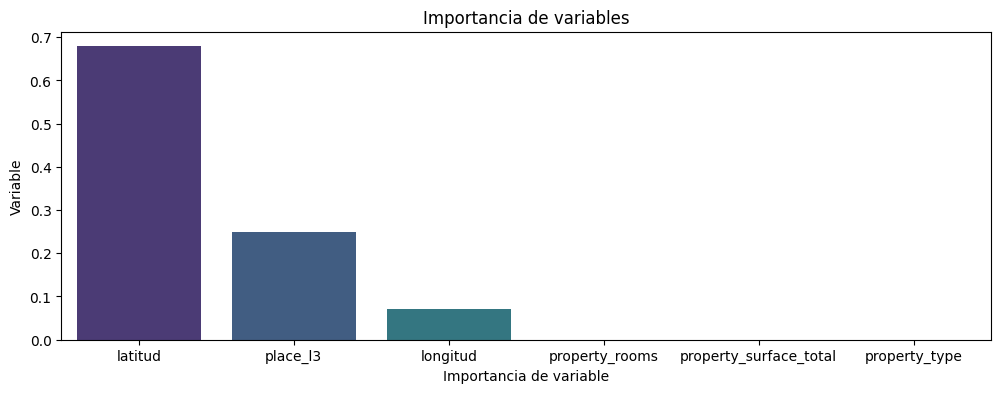

In [205]:
features = list(zip(x_train.columns.to_list(), best_dt_model.feature_importances_))

place_l3 = 0
property_type = 0
for name, val in features:
  if name.startswith('place_l3'):
    place_l3 += val
  if name.startswith('property_type'):
    property_type += val

features = [f for f in features if not f[0].startswith('place_l3')]
features = [f for f in features if not f[0].startswith('property_type')]
features.append(('place_l3', place_l3))
features.append(('property_type', property_type))

features = sorted(features, key=lambda x: -x[1])

# Extract feature names and importances
feature_names = [x[0] for x in features]
importances = [x[1] for x in features]
plotting_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(data=plotting_df, x='Variable', y='Importancia', palette='viridis')
plt.xlabel('Importancia de variable')
plt.ylabel('Variable')
plt.title('Importancia de variables')
plt.show()

#### Conclusión
Evaluar la performance del árbol en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.

In [206]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_test_pred_best_dt_model)
precision = precision_score(y_test, y_test_pred_best_dt_model, average='weighted')
recall = recall_score(y_test, y_test_pred_best_dt_model, average='weighted')
f1 = f1_score(y_test, y_test_pred_best_dt_model, average='weighted')

print("Métricas de evaluación en el conjunto de prueba:")
print("Exactitud (Accuracy): {:.2f}".format(accuracy))
print("Precisión (Precision): {:.2f}".format(precision))
print("Recall (Sensibilidad): {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))


Métricas de evaluación en el conjunto de prueba:
Exactitud (Accuracy): 0.41
Precisión (Precision): 0.40
Recall (Sensibilidad): 0.41
F1-score: 0.40


### Modelo 2: Random Forest


#### Construcción

Separo el training dataset en dos datasets `x`, `y` donde `y` son los labels de las clases que se quieren predecir y `x` son el resto de columnas a ser usadas para la prediccion.

In [189]:
# Creo x_train para entrenar e y_train para las labels, lo mismo para test
x_train = ds_clas_train.drop(columns=["tipo_precio"])
y_train = ds_clas_train["tipo_precio"].copy()

x_test = ds_clas_test.drop(columns=["tipo_precio"])
y_test = ds_clas_test["tipo_precio"].copy()

##### Cross-validation

Se toma un K-folds de `5` para hacer cross validation con el modelo de random forest y optimizando las metricas `accuracy, f1 score, area bajo la curva` (ya que son muy utilizadas para describir la performance de un modelo de clasificacion) usando como param_grid los siguientes parametros:

* Criterion: gini, entropy
* Cantidad de arboles: 25, 50, 100
* Min de samples por hoja: 1, 5, 10
* Min de samples por split: 2, 4, 10, 12, 16

In [ ]:
kfoldcv = KFold(n_splits=5)
scorer_fn = make_scorer(f1_score, average='macro')
n = 50

rf_model = RandomForestClassifier(oob_score=True, random_state=RAND_SEED, n_jobs=-1)

params_grid = {'criterion':["gini", "entropy"],
               'max_features':['sqrt', 'log2'],
               'min_samples_leaf': list(range(1, 50, 5)),
               'min_samples_split': list(range(1, 50, 5)),
               'n_estimators': list(range(10, 150, 10)),
               }

rs = RandomizedSearchCV(estimator=rf_model, param_distributions=params_grid, scoring=scorer_fn, cv=kfoldcv, n_iter=n, n_jobs=-1)
rs_fit = rs.fit(X = x_train, y = y_train) # entrenamiento
rs_fit.best_score_

Vemos en un grafico los resultados de las metricas para ver si detectamos un mejor modelo que el elegido por la cross validation.

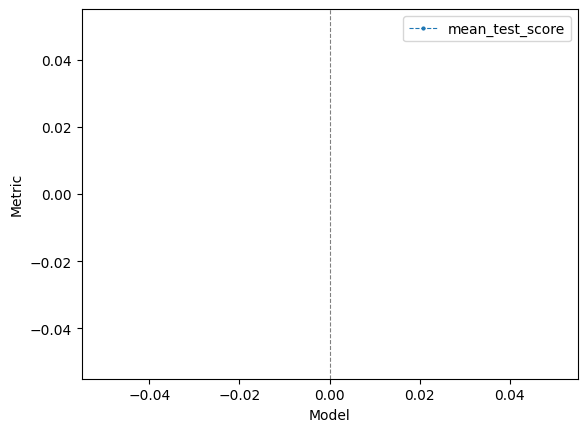

In [ ]:
# Filter out keys related to mean test scores for various metrics
labels = [key for key in rs_fit.cv_results_.keys() if "mean_test" in key]

# Plot each metric line
for k in labels:
    plt.plot(rs_fit.cv_results_[k], linestyle='--', linewidth=0.8, marker='o', markersize=2)

# Plot the vertical line at the maximum value for each metric
for k in labels:
    x_linea = np.argmax(rs_fit.cv_results_[k])
    plt.axvline(x_linea, linestyle='--', linewidth=0.8, color='grey')

plt.xlabel("Model", fontsize=10)
plt.ylabel("Metric", fontsize=10)
plt.legend(labels)
plt.show()

######### ESTA ROTO ----> TODO ARREGLAR --> SOLO GRAFICA 1

Vemos los mejores parametros resultantes.

In [ ]:
params_elegidos=rs_fit.cv_results_['params'][np.argmax(rs_fit.cv_results_['mean_test_score'])]
params_elegidos

{'n_estimators': 20,
 'min_samples_split': 20,
 'min_samples_leaf': 38,
 'max_features': 'sqrt',
 'criterion': 'gini'}

##### Creacion del mejor modelo

Teniendo en cuenta lo visto anteriormente creamos un random forest con los mejores parametros para poder entrenarlo con el training set completo y luego usar dicho modelo para predecir el `tipo_precio` del testing set.

In [192]:
#Creamos el MEJOR clasificador RF encontrado
best_rf = RandomForestClassifier(
    criterion = params_elegidos['criterion'],
    min_samples_leaf = params_elegidos['min_samples_leaf'],
    min_samples_split = params_elegidos['min_samples_split'],
    n_estimators = params_elegidos['n_estimators'],
    max_features = params_elegidos['max_features'],
    oob_score=True, random_state=RAND_SEED, n_jobs=-1
    )

#Entrenamos un modelo
best_rf_model = best_rf.fit(X = x_train, y = y_train)

# Hacemos predicciones para luego comparar resultados en entrenamiento y testing
y_train_pred_best_rf_model = best_rf_model.predict(x_train)
y_test_pred_best_rf_model = best_rf_model.predict(x_test)

Ahora en base a las predicciones dadas sobre el testing dataset, graficamos una matriz de confusion y damos un reporte de metricas.

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      6021
           1       0.23      0.26      0.24      6014
           2       0.22      0.18      0.20      6019

    accuracy                           0.39     18054
   macro avg       0.38      0.39      0.39     18054
weighted avg       0.38      0.39      0.39     18054



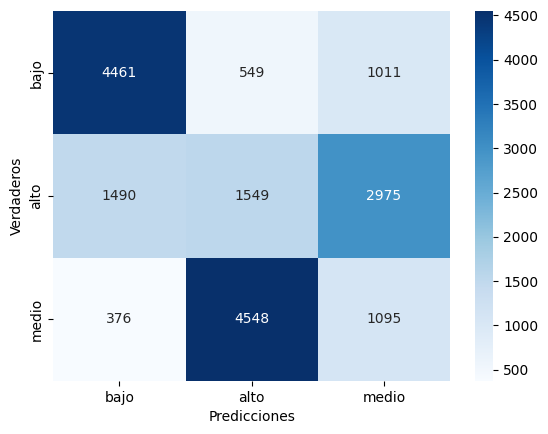

In [193]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test, y_test_pred_best_rf_model)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')

# Replace numeric labels with class representations
center = 0.5
plt.xticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])
plt.yticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])

#Reporte
print(classification_report(y_test, y_test_pred_best_rf_model))

Vemos como se desempeña sobre los mismos datos con los que entreno a modo de comparacion con las metricas de validacion anteriormente vistas.

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     24073
           1       0.75      0.83      0.79     24066
           2       0.72      0.62      0.67     24077

    accuracy                           0.75     72216
   macro avg       0.75      0.75      0.74     72216
weighted avg       0.75      0.75      0.74     72216



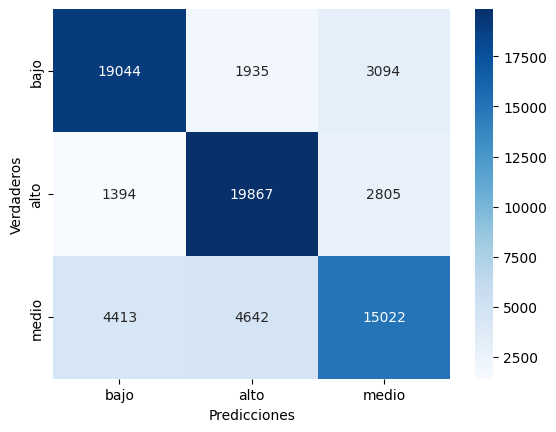

In [194]:
#Creo matriz de confusión
tabla=confusion_matrix(y_train, y_train_pred_best_rf_model)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')

# Replace numeric labels with class representations
center = 0.5
plt.xticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])
plt.yticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])

#Reporte
print(classification_report(y_train, y_train_pred_best_rf_model))

Como se puede ver este modelo dio resultados decentes al predecir si el precio de una propiedad es bajo, medio o alto, utilizando las variables place_l3, property_type, property_rooms y property_surface_total.

Tambien vemos que es mejor al predecir cuando una propiedad es de precio `medio` y la clase que peor predice es la de precio `bajo`. Esto puede deberse a que hay bastantes mas muestras del primer tipo que de los demas.

#### Importancia de atributos

Vemos la **importancia de gini** de cada feature del dataset

Primero concateno train y test para analizar sobre todos los datos.

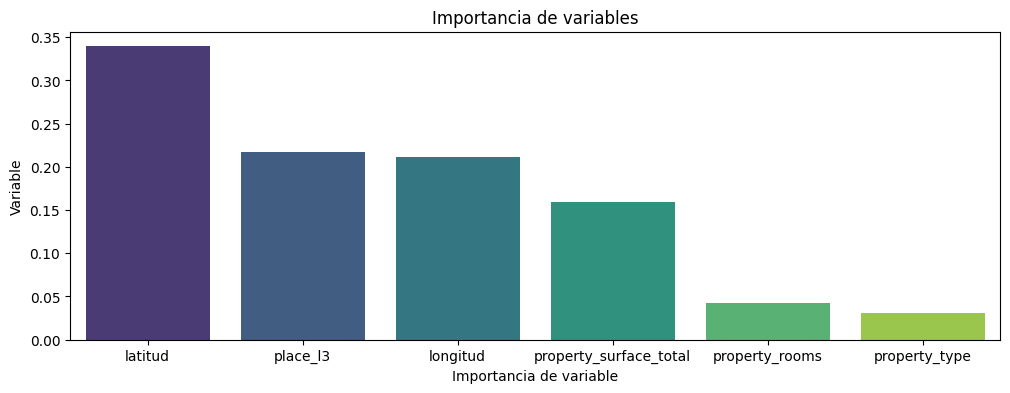

In [195]:
features = list(zip(x_train.columns.to_list(), best_rf_model.feature_importances_))

place_l3 = 0
property_type = 0
for name, val in features:
  if name.startswith('place_l3'):
    place_l3 += val
  if name.startswith('property_type'):
    property_type += val

features = [f for f in features if not f[0].startswith('place_l3')]
features = [f for f in features if not f[0].startswith('property_type')]
features.append(('place_l3', place_l3))
features.append(('property_type', property_type))

features = sorted(features, key=lambda x: -x[1])

# Extract feature names and importances
feature_names = [x[0] for x in features]
importances = [x[1] for x in features]
plotting_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(data=plotting_df, x='Variable', y='Importancia', palette='viridis')
plt.xlabel('Importancia de variable')
plt.ylabel('Variable')
plt.title('Importancia de variables')
plt.show()

Como podemos ver en este grafico sobre los features con los cuales se predice el `tipo_precio`, tenemos dos claras variables que son las mas importantes para este uso, estas son el `place_l3` o el **barrio** y la superficie total de la propiedad.

Esto se correlaciona con lo anteriormente visto en la seccion de construccion de target, donde se ve que la ubicacion geografica de las propiedades tiene una clara influencia en su precio.

#### Visualización de un arbol de decicion

En esta seccion visualizaremos el arbol de decision numero `50` hasta la profundidad `2` (no mas ya que se vuelve dificil de leer) y analizaremos esta primera capa de clasificacion.

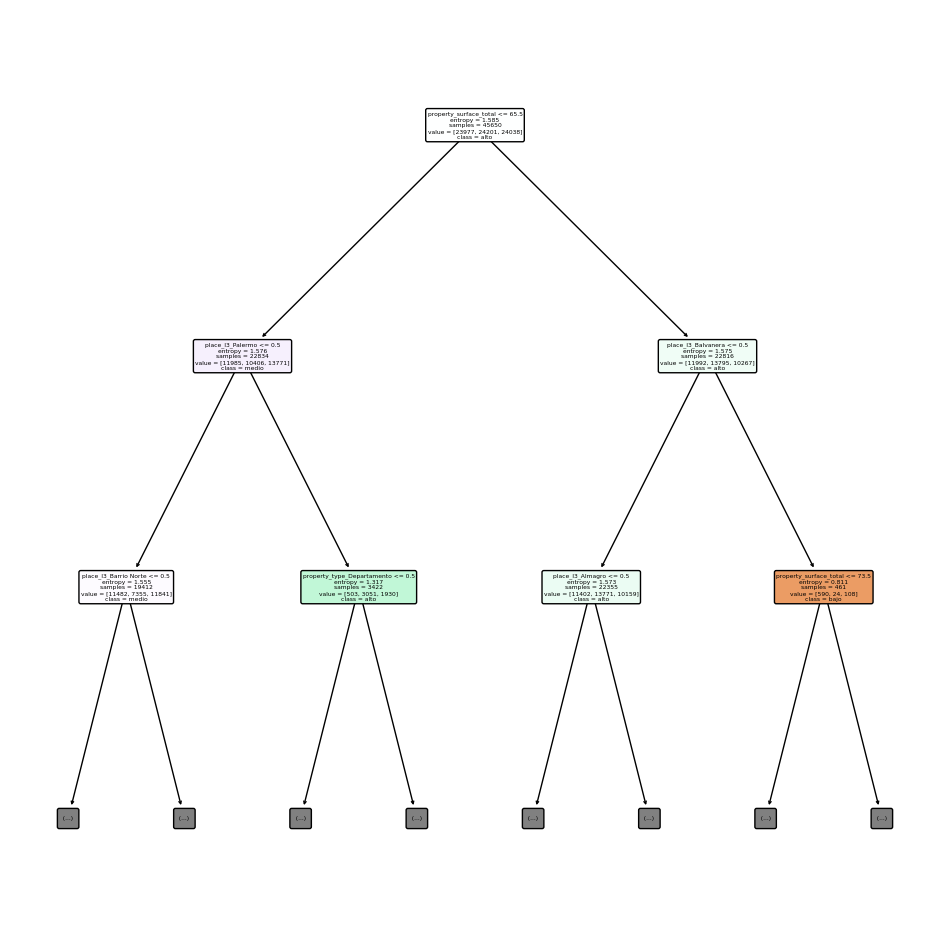

In [197]:
PROFUNDIDAD = 2
ARBOL_NUMERO = 10

plt.figure(figsize=(12,12))
tree_plot=tree.plot_tree(
    best_rf_model.estimators_[ARBOL_NUMERO],
    max_depth=PROFUNDIDAD,
    feature_names=x_train.columns.to_list(),
    filled=True,
    rounded=True,
    class_names=['bajo', 'alto', 'medio']
    )
plt.show(tree_plot)

Como se puede apreciar en el grafico el arbol comienza filtrando por `place_l3` <= 11.5 lo que quiere decir que mandara a todos los samples que no superan eso hacia el nodo izquierdo donde se filtraran por otro atributo diferente, y a los que superan el umbral los mandara a la derecha donde habra otra instancia de filtro pero por la misma variable y esta vez con un valor mayor (incrementando el umbral).

Tambien en cada nodo podemos ver el Gini entre las muestras que se tienen en ese momento.

Las muestras logicamente al ser filtradas disminuyen en cantidad a medida que bajan en el arbol de decision.

Adicionalmente en cada nodo podemos ver la prediccion hecha sobre todas las muestras de este:

* y[0] representa los precios medios
* y[1] los bajos (no hay ninguno en este grafico)
* y[2] los altos

#### Conclusión
Evaluar la performance del modelo en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.

### Modelo 3: a elección <font color="#e02626"></font>

Se eligio XGBoost de clasificacion

#### Construcción


In [180]:
# Creo x_train para entrenar e y_train para las labels, lo mismo para test
x_train = ds_clas_train.drop(columns=["tipo_precio"])
y_train = ds_clas_train["tipo_precio"].copy()

x_test = ds_clas_test.drop(columns=["tipo_precio"])
y_test = ds_clas_test["tipo_precio"].copy()

##### Cross-validation

In [ ]:
kfoldcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer_fn = make_scorer(f1_score, average='macro')

xbg_model = XGBClassifier(random_state=RAND_SEED)

params_grid = {
    "n_estimators": [100],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.5, 0.75, 1.0],
    "colsample_bytree": [0.5, 0.75, 1.0],
}

grid_search = GridSearchCV(estimator=xbg_model, param_grid=params_grid, scoring=scorer_fn, cv=kfoldcv)
grid_result = grid_search.fit(x_train, y_train) # entrenamiento
best_score = grid_result.best_score_

Vemos los mejore hiperparametros seleccionados

In [ ]:
params_elegidos=grid_result.cv_results_['params'][np.argmax(grid_result.cv_results_['mean_test_score'])]
params_elegidos

##### Creacion de modelo

In [182]:
best_xgb_model = XGBClassifier(
    random_state=RAND_SEED,
    n_estimators = params_elegidos['n_estimators'],
    learning_rate = params_elegidos['learning_rate'],
    max_depth = params_elegidos['max_depth'],
    subsample = params_elegidos['subsample'],
    colsample_bytree = params_elegidos['colsample_bytree'],
    )

best_xgb_model.fit(X=x_train, y=y_train)
y_train_pred_best_xgb_model = best_xgb_model.predict(x_train)
y_test_pred_best_xgb_model = best_xgb_model.predict(x_test)

Vemos como se desempeña en el testing set

              precision    recall  f1-score   support

           0       0.63      0.72      0.67     24073
           1       0.61      0.73      0.66     24066
           2       0.50      0.33      0.40     24077

    accuracy                           0.59     72216
   macro avg       0.58      0.59      0.58     72216
weighted avg       0.58      0.59      0.58     72216



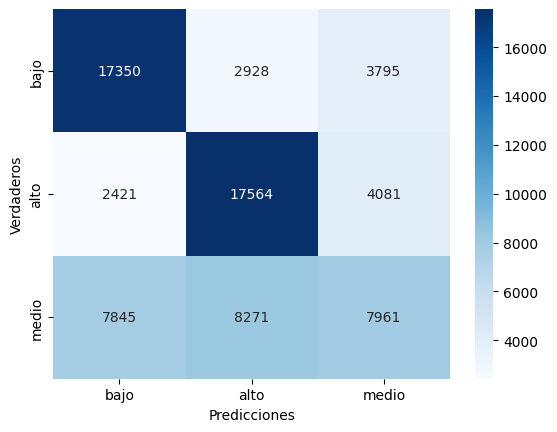

In [183]:
#Creo matriz de confusión
tabla=confusion_matrix(y_train, y_train_pred_best_xgb_model)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')

# Replace numeric labels with class representations
center = 0.5
plt.xticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])
plt.yticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])

#Reporte
print(classification_report(y_train, y_train_pred_best_xgb_model))

Vemos como se desempeña sobre el training set

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      6021
           1       0.29      0.34      0.31      6014
           2       0.27      0.18      0.21      6019

    accuracy                           0.41     18054
   macro avg       0.39      0.41      0.40     18054
weighted avg       0.39      0.41      0.40     18054



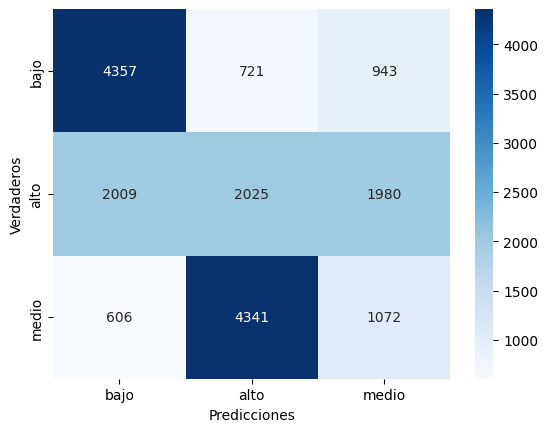

In [185]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test, y_test_pred_best_xgb_model)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')

# Replace numeric labels with class representations
center = 0.5
plt.xticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])
plt.yticks(ticks=np.arange(len(tipo_precio_inv_dict)) + center, labels=[tipo_precio_inv_dict[i] for i in range(len(tipo_precio_inv_dict))])

#Reporte
print(classification_report(y_test, y_test_pred_best_xgb_model))

#### Importancia de atributos

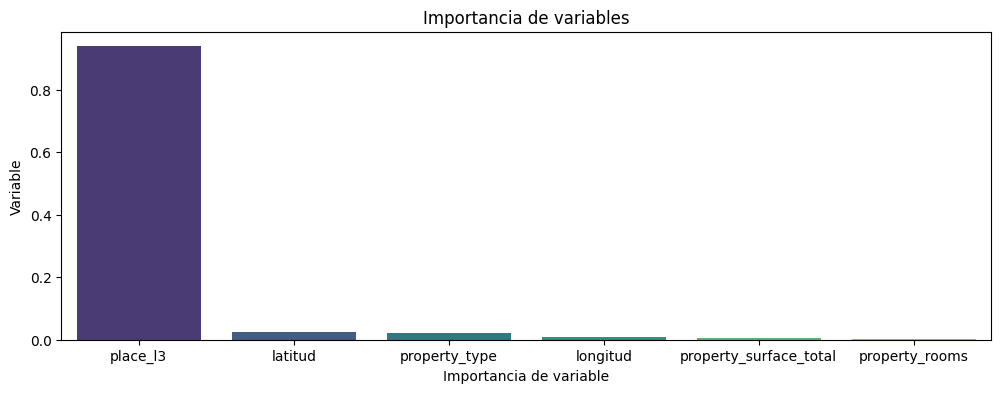

In [188]:
features = list(zip(x_train.columns.to_list(), best_xgb_model.feature_importances_))

place_l3 = 0
property_type = 0
for name, val in features:
  if name.startswith('place_l3'):
    place_l3 += val
  if name.startswith('property_type'):
    property_type += val

features = [f for f in features if not f[0].startswith('place_l3')]
features = [f for f in features if not f[0].startswith('property_type')]
features.append(('place_l3', place_l3))
features.append(('property_type', property_type))

features = sorted(features, key=lambda x: -x[1])

# Extract feature names and importances
feature_names = [x[0] for x in features]
importances = [x[1] for x in features]
plotting_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(data=plotting_df, x='Variable', y='Importancia', palette='viridis')
plt.xlabel('Importancia de variable')
plt.ylabel('Variable')
plt.title('Importancia de variables')
plt.show()

#### Conclusión

Eligimos el modelo XGBoost el cual fue entrenado utilizando una búsqueda exhaustiva de hiperparámetros y validación cruzada. Se aplicaron técnicas de ingeniería de características, como codificación de variables categóricas y normalización de características numéricas, para mejorar el rendimiento del modelo. La importancia de las características se visualizó para comprender mejor qué variables afectan más a las predicciones del modelo. Finalmente, se evaluó el modelo en el conjunto de entrenamiento utilizando métricas de clasificación y una matriz de confusión, lo que proporcionó información sobre su rendimiento general.

## Guardado de modelos

In [212]:
if using_drive:
  joblib.dump(best_dt_model, drive_path + '/Models/best_dt_model.pkl')
  joblib.dump(best_rf_model, drive_path + '/Models/best_rf_model.pkl')
  joblib.dump(best_xgb_model, drive_path + '/Models/best_xgb_model.pkl')
else:
  joblib.dump(best_dt_model, './models/best_dt_model.pkl')
  joblib.dump(best_rf_model, './models/best_rf_model.pkl')
  joblib.dump(best_xgb_model, './models/best_xgb_model.pkl')